## Breakout session: semi-detached and contact binaries in PHOEBE

In [1]:
import phoebe
import numpy as np
%matplotlib inline

Connection to online passbands at http://tables.phoebe-project.org could not be established.  Check your internet connection or try again later (can manually call phoebe.list_online_passbands(refresh=True) to retry).  If the problem persists and you're using a Mac, you may need to update openssl (see http://phoebe-project.org/help/faq). Original error from urlopen: URLError <urlopen error timed out>


### SEMI - DETACHED

Building a semi-detached system in Phoebe is very straight-forward. All you need to do is add a 'semidetached' constraint to the desired component in the Bundle, which will fix the component's radius to the critical one.

Let's start with the default Bundle, as usual:

In [2]:
b = phoebe.default_binary()

Assuming that the primary star in our binary is filling it's Roche lobe, we can add a semidetached constraint as:

In [3]:
b.add_constraint('semidetached', 'primary')

<ParameterSet: 1 parameters>

The above call adds a constraint on the requiv of the primary star. We can view it by accessing the constraint:

In [4]:
b['requiv@constraint@primary']

<ConstraintParameter: {requiv@primary@component} = 1.000000 * {requiv_max@primary@component} (solar units) => 2.013275176537638 solRad>

Now whenever any of the relevant parameters (q, ecc, syncpar, sma) are changed, the value of requiv will change to match the critical value as defined by requiv_max. Let's change some of the parameters and see how it affects the value of the constrained requiv:

In [5]:
b['q'] = 1.3
b['requiv@constraint@primary']

<ConstraintParameter: {requiv@primary@component} = 1.000000 * {requiv_max@primary@component} (solar units) => 1.8918996589708539 solRad>

In [6]:
b['sma@binary'] = 6.
b['requiv@constraint@primary']

<ConstraintParameter: {requiv@primary@component} = 1.000000 * {requiv_max@primary@component} (solar units) => 2.141773198834929 solRad>

Let's finally add, compute and plot the mesh of the above system.

In [7]:
b.add_dataset('mesh', times=[0.25])

<ParameterSet: 85 parameters | contexts: dataset, figure, constraint, compute>

In [8]:
b.run_compute(irrad_method='none')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.96it/s]


<ParameterSet: 11 parameters | components: secondary, primary>

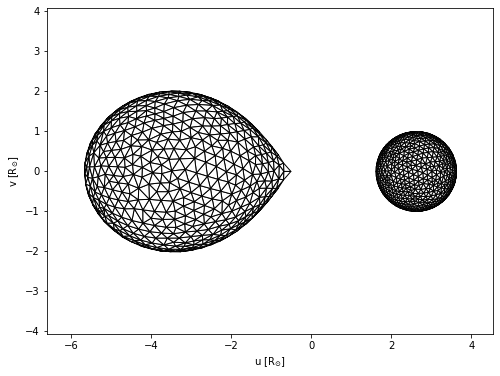

In [9]:
afig, mplfig = b.plot(show=True)

### CONTACT

A contact binary Bundle is created by passing **contact_binary=True** to the default binary bundle.

In [10]:
cb = phoebe.default_binary(contact_binary = True)

The main difference between the detached and contact binary Bundles is in the *hierarchy* of the system. In addition to the two star components, contact binaries have an **envelope component** as well.

In [11]:
print(cb.hierarchy)


    orbit:binary
    
        star:primary
        star:secondary
        envelope:contact_envelope
    



The parameters of the system are distributed between the star and envelope components. The stellar parameters, like mass, radius, temperature, etc. are attached to the primary and secondary star components. The overall (shared) parameters, like potential, fillout factor, metallicity, etc. are attached to the envelope component. For a full list of parameters associated with each component, we can filter on them:

In [12]:
print(cb.filter(context='component', kind='star', component='primary'))

ParameterSet: 17 parameters
         requiv@primary@component: 1.5 solRad
C    requiv_max@primary@component: 1.6724563972838384 solRad
C    requiv_min@primary@component: 1.2725418568681297 solRad
           teff@primary@component: 6000.0 K
C          logg@primary@component: 4.089736163094955
        syncpar@primary@component: 1.0
C        period@primary@component: 0.5 d
C          freq@primary@component: 12.56637 rad / d
      gravb_bol@primary@component: 0.32
   irrad_frac_refl_bol@primary...: 0.6
C  irrad_frac_lost_bol@primary...: 0.4
    ld_mode_bol@primary@component: lookup
    ld_func_bol@primary@component: logarithmic
   ld_coeffs_source_bol@primar...: auto
C          mass@primary@component: 1.0089067994531355 solMass
C           sma@primary@component: 1.675 solRad
C         asini@primary@component: 1.675 solRad


In [13]:
print(cb.filter(context='component', kind='star', component='secondary'))

ParameterSet: 17 parameters
C      requiv@secondary@component: 1.4999999999999996 solRad
C  requiv_max@secondary@component: 1.6724563972838378 solRad
C  requiv_min@secondary@component: 1.2725418568681297 solRad
         teff@secondary@component: 6000.0 K
C        logg@secondary@component: 4.089736163094955
      syncpar@secondary@component: 1.0
C      period@secondary@component: 0.5 d
C        freq@secondary@component: 12.56637 rad / d
    gravb_bol@secondary@component: 0.32
   irrad_frac_refl_bol@seconda...: 0.6
C  irrad_frac_lost_bol@seconda...: 0.4
   ld_mode_bol@secondary@compo...: lookup
   ld_func_bol@secondary@compo...: logarithmic
   ld_coeffs_source_bol@second...: auto
C        mass@secondary@component: 1.0089067994531355 solMass
C         sma@secondary@component: 1.675 solRad
C       asini@secondary@component: 1.675 solRad


As before, the parameters marked with a `C` are constrained by other parameters. If we compare the primary and secondary, we notice that the equivalent radius (requiv) of the primary is a free parameter, while the secondary requiv is constrained by the envelope potential, mass ratio and semi-major axis of the system:

In [14]:
print(cb['requiv@secondary@constraint'])

Constrains (qualifier): requiv
Expression in solar units (value): pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
Current Result (result): 1.4999999999999996 solRad


This is one way in which the implementation of contact binaries in PHOEBE differes from the detached systems. The relative sizes of the two stars are "linked" through the shared envelope potential and mass ratio of the system, thus only the primary requiv needs to be provided by the user.

Let's filter on the envelope component:

In [15]:
print(cb.filter(context='component', kind='envelope'))

ParameterSet: 5 parameters
   abun@contact_envelope@compo...: 0.0
C  fillout_factor@contact_enve...: 0.6417897080770951
C  pot@contact_envelope@component: 3.4013774072298766
C  pot_min@contact_envelope@co...: 3.2067962240861534
C  pot_max@contact_envelope@co...: 3.75


As you can see, all of the envelope parameters except the abundance are constrained. Let's check which parameters constrain the fillout factor and potential:

In [16]:
print(cb['fillout_factor@contact_envelope@constraint'])

Constrains (qualifier): fillout_factor
Expression in solar units (value): pot_to_fillout_factor({q@binary@component}, {pot@contact_envelope@component})
Current Result (result): 0.6417897080770951


In [17]:
print(cb['pot@contact_envelope@constraint'])

Constrains (qualifier): pot
Expression in solar units (value): requiv_to_pot_contact({requiv@primary@component}, {q@binary@component}, {sma@binary@component}, 1)
Current Result (result): 3.4013774072298766


From the above two calls we can see that the fillout factor is constrained by the potential of the envelope, which is in turn constrained by the primary equivalent radius. This allows for a lot of freedom in terms of which parameters are chosen to describe a contact binary system - if we're comparing to evolutionary simulations, we probably know the values of the equivalent radii or the fillout factor; if we have a phoebe-legacy model, we know the value of the potential instead. This allows for easy and accurate comparison with other codes and models.

#### ** Note on fillout factor

There are several different definitions of the fillout factor used in the literature. In Phoebe we use the following:
\begin{equation}
FF = \frac{\Omega - \Omega_{L1}}{\Omega_{L23} - \Omega_{L1}}
\end{equation}
where $\Omega$ is the envelope potential, and $\Omega_{L1}$ and $\Omega_{L23}$ are the inner and outer critical potentials, respectively. Thus, the fillout factor is 0 at the inner and 1 at the outer critical potential.

To be able to set the potential, you just need to flip the constraint to solve for requiv@primary:

In [18]:
cb.flip_constraint('pot@contact_envelope', solve_for='requiv@primary')

<ConstraintParameter: {requiv@primary@component} = pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1) (solar units) => 1.5 solRad>

The fillout factor is constrained by the potential, so to be able to set it, we need to do another constraint flip:

In [19]:
cb.flip_constraint('fillout_factor', solve_for='pot@contact_envelope')

<ConstraintParameter: {pot@contact_envelope@component} = fillout_factor_to_pot({q@binary@component}, {fillout_factor@contact_envelope@component}) (solar units) => 3.4013774072298766>

#### Meshes, datasets, compute

Everything else works the same as for detached systems, with certain contact binary - related precautions that need to be taken into account. We'll get to them in this section.

Let's add a mesh and light curve dataset, compute and plot the model.

In [20]:
cb.add_dataset('mesh', times=[0.125], dataset='mesh01', columns=['teffs'], overwrite=True)
cb.add_dataset('lc', times=np.linspace(0.,0.5,50), dataset='lc01', overwrite=True)

<ParameterSet: 80 parameters | contexts: dataset, figure, constraint, compute>

In [21]:
cb.run_compute()

100%|███████████████████████████████████████████| 51/51 [00:03<00:00, 14.78it/s]


<ParameterSet: 15 parameters | kinds: lc, mesh>

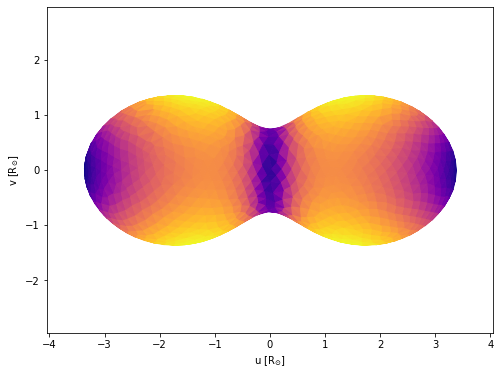

In [22]:
_ = cb.plot('mesh01', fc='teffs', ec='face', fcmap='plasma', show=True)

*Fun, but impractical* - since the mesh is still assigned to each component separately, we can also plot just a half of the envelope that pertains to one star:

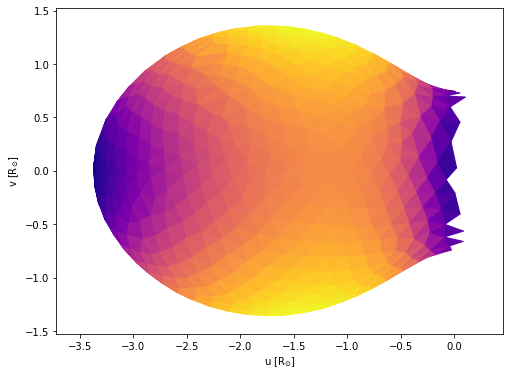

In [23]:
_ = cb.plot('mesh01@primary', fc='teffs', ec='face', fcmap='plasma', show=True)

While the plot may not be super useful scientifically, accessing the mesh parameters for the primary and secondary separately could be quite useful if you are interested in the relative light ratios of the two components at a specific phase.  While this is not included in PHOEBE natively, you can use the mesh elements and calculate this yourself.

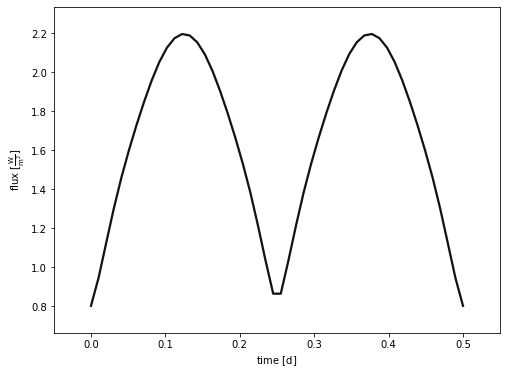

In [24]:
_ = cb.plot('lc01', show=True)

The way the surface temperature values are assigned is also component-dependent, so the two "halves" of the envelope are treated like single, separate stars that are separated in the neck by an artifical boundary that the code introduces. This treatment was first implemented in W-D and we are working towards a better, more physical solution.

To illustrate the component splitting in terms of temperature distribution, let's change one of the effective temperatures and the recommended values of gravity brightening and reflection coefficient for that temperature:

In [25]:
cb.set_value('teff', component='primary', value=9000.)

In [26]:
cb.set_value('gravb_bol', component='primary', value=1.)
cb.set_value('irrad_frac_refl_bol', component='primary', value=1.)

In [27]:
cb.run_compute()

100%|███████████████████████████████████████████| 51/51 [00:03<00:00, 14.79it/s]


<ParameterSet: 15 parameters | kinds: lc, mesh>

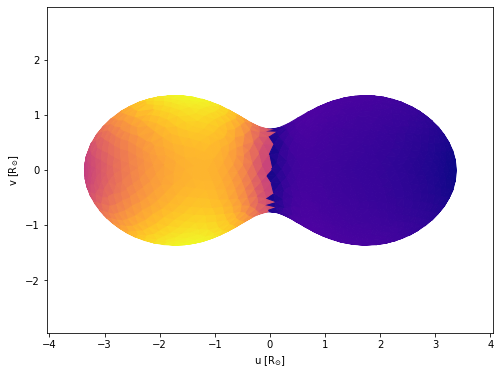

In [28]:
_ = cb.plot('mesh01', facecolor='teffs', ec='face', fcmap='plasma', show=True)

### Failed meshes

Because the mesh of a contact binary envelope is not convex, certain combinations of parameters (i.e. very low or very high fillout factor, very low mass ratio) can lead to failing or weird marching meshes.

In [29]:
cb['q'] = 0.1
cb['fillout_factor'] = 0.05

In [30]:
cb.run_compute()

Start
0.7029722068099485 -0.001507970082238075 -0.01894901278296258
0.2215773838590294 -0.008396607833681303 -0.1263549126202019
-0.003651789212662848
End
0.7200909198686137 0.009579621070215262 0.02905694158098952
-0.02258747837559438 0.05795913248520744 0.2077644878544834
2.220446049250313e-16


TypeError: Projections are failing!

There is no direct solution to an issue like this one - in cases of small fillout factors it might work to use a detached system close to contact instead or increase the value of the fillout factor until a mesh can be created successfully. 

In other cases it's sufficient to increase the number of triangles. For example:

In [31]:
cb['q'] = 0.1
cb['fillout_factor'] = 0.1

In [32]:
cb.run_compute()

TypeError: Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!

In [33]:
cb.run_compute(ntriangles=5000) # will compute successfully

100%|███████████████████████████████████████████| 51/51 [00:06<00:00,  7.49it/s]


<ParameterSet: 15 parameters | kinds: lc, mesh>

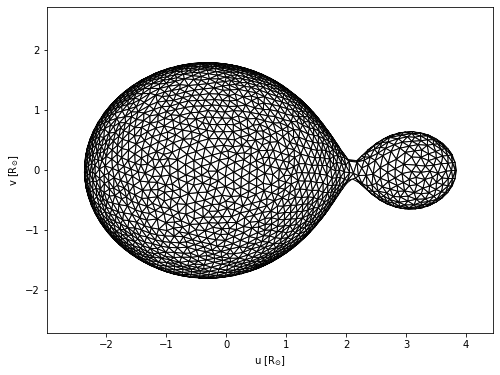

In [34]:
ax, artists = cb.plot('mesh01', show=True)